In [1]:
import numpy as np
import h5py 
import pycap
from pandas import DataFrame

In [2]:
# define dictionaries we'll use later
sys_dict = {"molecule": "molcas_rassi",
"basis_file": "anion_ms.rassi.h5"}

cap_dict = {
            "cap_type": "box",
            "cap_x":"2.76",
            "cap_y":"2.76",
            "cap_z":"4.88",
            "Radial_precision": "14",
            "angular_points": "110"
}

In [3]:
# read in electronic structure data
es_dict = {"method" : "ms-caspt2",
           "molcas_output":"anion_ms.out",
           "rassi_h5":"anion_ms.rassi.h5",
}
s = pycap.System(sys_dict)
pc = pycap.Projected_CAP(s,cap_dict,10,"openmolcas")
pc.read_data(es_dict)

Number of basis functions:119
Successfully read in zeroth order Hamiltonian from file:anion_ms.out
Successfully read in densities from file:anion_ms.rassi.h5


In [4]:
# do cap calculation, print matrices
pc.compute_ao_cap()
pc.compute_projected_cap()
mat=pc.get_projected_cap()
h0 = pc.get_H()
print("Zeroth order Hamiltonian")
print(DataFrame(h0).to_string(index=False, header=False))
print("CAP matrix")
print(DataFrame(mat).to_string(index=False, header=False))

Calculating CAP matrix in AO basis...
Integration time:2.099167
Zeroth order Hamiltonian
-109.305207    0.000000   -0.002096    0.000047    0.003537   -0.000095    0.002081    0.000062   -0.000000    0.000000
   0.000000 -109.305207   -0.000047   -0.002096    0.000095    0.003537    0.000062   -0.002081    0.000000    0.000000
  -0.002096   -0.000047 -109.240716    0.000000    0.027058   -0.000124    0.019630    0.000144   -0.000000   -0.000000
   0.000047   -0.002096    0.000000 -109.240716    0.000124    0.027058    0.000144   -0.019630    0.000000    0.000000
   0.003537    0.000095    0.027058    0.000124 -109.217809    0.000000   -0.048231   -0.000134    0.000000    0.000000
  -0.000095    0.003537   -0.000124    0.027058    0.000000 -109.217809   -0.000134    0.048231    0.000000   -0.000000
   0.002081    0.000062    0.019630    0.000144   -0.048231   -0.000134 -109.072141   -0.000000   -0.000000    0.000000
   0.000062   -0.002081    0.000144   -0.019630   -0.000134    0.048231

In [6]:
# pass densities as numpy arrays
# set up stuff for hdf5
f = h5py.File('anion_ms.rassi.h5', 'r')
arr = f["SFS_TRANSITION_DENSITIES"]
pc = pycap.Projected_CAP(s,cap_dict,10,"openmolcas")
pc = pycap.Projected_CAP(s,cap_dict,10,"openmolcas")
for i in range(0,10):
    for j in range(i,10):
        arr1 = 0.5*np.reshape(arr[i][j],(119,119))
        pc.add_tdms(arr1,arr1,i,j,"openmolcas","anion_ms.rassi.h5")
        if i!=j:
            pc.add_tdms(arr1,arr1,j,i,"openmolcas","anion_ms.rassi.h5")

In [11]:
pc.get_ao_cap()

array([], shape=(0, 0), dtype=float64)

In [14]:
#check overlap matrix
arr2 = np.array(f["AO_OVERLAP_MATRIX"])
arr2 = np.reshape(arr2,(119,119))
smat = s.get_overlap_mat()
print(np.shape(smat))
s.check_overlap_mat(arr2,"openmolcas","anion_ms.rassi.h5")

(119, 119)
Verified overlap matrix.


In [15]:
import os
import functools
from numpy import linalg as LA
import matplotlib.pyplot as plt
caspt2_energy = -109.35042571
E_0 = caspt2_energy
au2eV= 27.2113961
@functools.total_ordering
class root():
    def __init__(self, energy, eta):
        self.eta = eta
        self.energy = energy
    
    def __lt__(self, other):
        return self.eta < other.eta
    
    def __eq__(self, other):
        return self.eta == other.eta and self.eta == other.eta

class trajectory():
    def __init__(self,states,guess):
        min=500
        cur=-1
        for st in states:
            if np.absolute(st.energy-guess)<min:
                cur=st
                min=np.absolute(st.energy-guess)
        self.last=cur
        self.states=[cur]
    
    def add_state(self,states):
        min=500
        cur=-1
        for st in states:
            if np.absolute(st.energy-guess)<min:
                cur=st
                min=np.absolute(st.energy-self.last.energy)
        self.states.append(cur)
    
    def get_corrections(self):
        energies=[]
        etas=[]
        for st in self.states:
            energies.append(st.energy)
            etas.append(st.eta)
        derivs=list(np.gradient(energies)/np.gradient(etas))
        for i in range(0,len(self.states)):
            self.states[i].corr_energy=self.states[i].energy-derivs[i]*self.states[i].eta

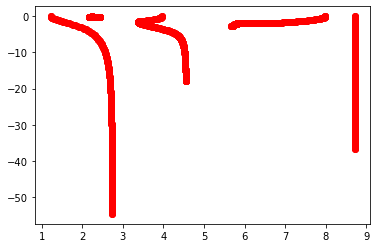

In [16]:
H_0 = h0
cap_mat = mat
guess=3
eta_list = np.linspace(0,3000,301)
eta_list = eta_list * 1E-5
all_roots=[]
for i in range(0,len(eta_list)):
    eta=eta_list[i]
    roots=[]
    fullH = H_0 +1.0j * eta * cap_mat
    eigv,eigvc=LA.eig(fullH)
    for eig in eigv:
        E = (eig - E_0) * au2eV
        roots.append(root(E,eta))
        all_roots.append(root(E,eta))
    if i==0:
        traj=trajectory(roots,guess)
    else:
        traj.add_state(roots)
re_traj = []
im_traj = []
energies=[]
for root in all_roots:
    re_traj.append(np.real(root.energy))
    im_traj.append(np.imag(root.energy))
    energies.append(root.energy)
plt.plot(re_traj,im_traj,'ro')
plt.show()

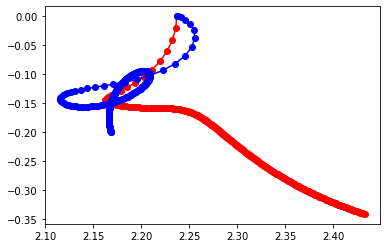

In [17]:
#plot trajectories of interest
traj.get_corrections()
re_traj = []
im_traj = []
corr_re=[]
corr_im=[]
uc_energies=[]
corr_energies=[]
for root in traj.states:
    uc_energies.append(root.energy)
    re_traj.append(np.real(root.energy))
    im_traj.append(np.imag(root.energy))
    corr_re.append(np.real(root.corr_energy))
    corr_im.append(np.imag(root.corr_energy))
    corr_energies.append(root.corr_energy)
plt.plot(re_traj,im_traj,'-ro')
plt.plot(corr_re,corr_im,'-bo')
plt.show()